In [1]:
# Make sure changes to libraries are seen
%load_ext autoreload
%autoreload 2

# Use full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Look in ../src/ for modules*
import sys;
sys.path.append("../src/")

# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from time import time
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing, disk
from scipy.ndimage.morphology import binary_closing
import scipy.ndimage as ndi
import h5py 
import os
from clustering import * 
from distributions import *

# Colormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
cm_reds   = ListedColormap([[1,0,0,alpha] for alpha in np.linspace(0,1,256)]);
cm_greens = ListedColormap([[0,1,0,alpha] for alpha in np.linspace(0,1,256)]);
cm_blues  = ListedColormap([[0,0,1,alpha] for alpha in np.linspace(0,1,256)]);
cm_purples= ListedColormap([[1,0,1,alpha] for alpha in np.linspace(0,1,256)]);
cm_yellows= ListedColormap([[1,1,0,alpha] for alpha in np.linspace(0,1,256)]);
cm_oranges= ListedColormap([[1,.5,0,alpha] for alpha in np.linspace(0,1,256)]);
color_maps = [cm_reds,cm_greens,cm_blues,cm_yellows,cm_oranges,cm_purples];

In [2]:
# Load data
tomo_path="../../Goats/tomograms/hdf5-byte/"
implant_threshold=2
experiment="770c"
scale=8 # scale^8 times smaller than full size

full_filename=f"{tomo_path}/scale/1x/{experiment}.h5"
scaled_filename=f"{tomo_path}/scale/{scale}x/{experiment}.h5"

f_scaled=h5py.File(scaled_filename,'r');
f_full=h5py.File(full_filename,'r');

subvolume_range=f_full['subvolume_range']
subvolume_dims=f_full['subvolume_dimensions']
global_min = subvolume_range[:,0].min()
global_max = subvolume_range[:,1].max()
print("(global_min, global_max) =",global_min, global_max)

full_voxels=f_full['voxels']
scaled_voxels=f_scaled['voxels']

(Nz,Ny,Nx) = full_voxels.shape
(nz,ny,nx) = scaled_voxels.shape

(global_min, global_max) = -2.32903552 6.56602716


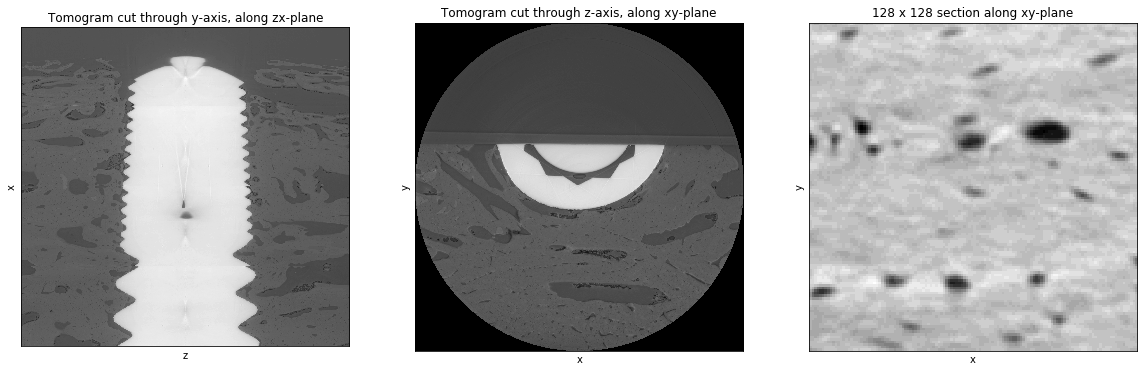

In [3]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(full_voxels[:,Ny//2,:],cmap="gray"); plt.xticks([]);  plt.yticks([])
plt.title("Tomogram cut through y-axis, along zx-plane")
plt.xlabel("z")
plt.ylabel("x")
plt.subplot(1,3,2)
plt.imshow(full_voxels[Nz//2,:,:],cmap="gray");  plt.xticks([]);  plt.yticks([])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Tomogram cut through z-axis, along xy-plane")
plt.subplot(1,3,3) 
#plt.imshow(full_voxels128[0,:,:],cmap="gray")
plt.imshow(full_voxels[Nz//2-64,(Ny//2+900)-64:(Ny//2+900)+64,Nx//2-64:Nx//2+64],cmap="gray");  plt.xticks([]);  plt.yticks([])
plt.title("128 x 128 section along xy-plane")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("figures/tomogramcutzandy.png",bbox_inches='tight')

In [4]:
# Functions
def get_probs(values_region, hist_region):
    # Data preprocessing
    #region   = np.logical_and(intensity>-1.0,intensity <= 2)
#     hist_region   = hist_sum[region];
#     values_region = intensity[region] 

    points_region = points_from_histogram(values_region,hist_region,N_points=5000);

    # K-Means
    n_clusters = 4; (centers,mins,maxs) = kMeans1D(points_region,n_clusters)

    # Assigning regions
    xs=values_region
    cluster_regions = np.array([np.logical_and(xs>=mins[i], xs<=maxs[i]) for i in range(n_clusters)])

    # Finding maxima
    maxima=np.array([np.argmax(hist_region[cluster_regions[i]]) for i in range(n_clusters)]) # get argument of max value in each region

    # Getting distribution parameters
    abcd = distributions_from_clusters(values_region,
                                           hist_region,n_clusters,
                                           overshoot_penalty=10,
                                           distribution_function=powers)

    # Getting distributions
    gs=powers(values_region,abcd)
    g_tot  = np.sum(gs,axis=0)

    # Get probabilities
    rho_tot = hist_region
    prob=np.minimum(gs/((rho_tot==0)+rho_tot),np.ones(gs.shape))
    
    
    ########################## Plotting ###########################
    colors = ['red','green','blue','yellow','orange','purple'];
    
#     # Plot whole histogram vs hist_region
#     plt.figure(figsize=(20,6))
#     plt.subplot(1,2,1); plt.plot(intensity,hist_sum); plt.axvspan(values_region[0],values_region[-1],color='r',alpha=0.2,label="Chosen Region"); plt.title("Full Histogram"); plt.legend()
#     plt.subplot(1,2,2); plt.plot(values_region,hist_region); plt.title("Histogram of Chosen Region")
#     plt.show()
    
#     # Check that points are distributed like the original points that generated the histogram
#     plt.figure(figsize=(20,6))
#     plt.subplot(1,2,1); plt.plot(values_region,hist_region); plt.title("Histogram of Original Data")
#     points_hist, points_bin_edges = np.histogram(points_region, bins=values_region)
#     plt.subplot(1,2,2); plt.plot(points_bin_edges[0:-1], points_hist),plt.title("Histogram of 5000 Generated Points")
#     plt.show()
    
#     # Plotting K-Means results
#     plt.figure(figsize=(20,6))
#     plt.subplot(1,2,1)
#     plt.plot(values_region,hist_region)
#     for i in range(n_clusters):
#         plt.axvspan(mins[i], maxs[i], alpha=0.5, color=colors[i])
#     # Plotting assigned regions
#     plt.subplot(1,2,2)
#     #plt.plot(xs,hist_region)
#     plt.plot(values_region,hist_region*100)
#     for i in range(n_clusters):
#         plt.plot(xs,cluster_regions[i]*4e8,color=colors[i])
#     plt.show()
    
#     # Plotting maxima
#     plt.figure(); plt.plot(values_region,hist_region)
#     for i in range(n_clusters):
#         plt.plot(xs[cluster_regions[i]],hist_region[cluster_regions[i]],color=colors[i])
#         plt.axvline(x=xs[cluster_regions[i]][maxima[i]])
#     plt.show()
        
    # Plotting distributions
    plt.figure(figsize=(20,6))
    plt.subplot(1,2,1); plt.plot(hist_region); plt.plot(g_tot); plt.title("Total Parts of Histogram Explained by Distributions")
    plt.subplot(1,2,2); plt.plot(hist_region)
    for g in gs:
        plt.plot(g)
    plt.title("Individual Distributions")
    plt.show()

#     # Plotting probabilities
#     plt.figure()
#     for i in range(4):
#         plt.plot(prob[i])
#     plt.title("Probabilities")
#     plt.show()

    return prob

def get_bone_area(tom_slice, bone_prob, region):
    # Preprocessing
    region_ix = np.argwhere(region)
    region_start = region_ix[0];
    region_end   = region_ix[-1];
    print("Region start, region end:",region_start,region_end)
    tom_slice_region = np.logical_and(tom_slice>=region_start, tom_slice<=region_end);
    tom  = (tom_slice-region_start)*tom_slice_region;
    
    # Overlaying bone mask 
    boneimg = bone_prob[tom] # Get bone mask 
    
    # > 90%
    bone_thresh = boneimg > 0.90 # pick the part that is bone with 90% certainty

    # closing
    closed_bone_mask = np.array(binary_closing(bone_thresh, disk(8)))
    
    # Make a circle mask
    (Ny,Nx)=boneimg.shape
    R  = Nx/2;
    xs = np.linspace(-R,R,Nx)
    ys = np.linspace(-R,R,Ny)
    rs = np.sqrt(xs[:,None]**2 + ys[None,:]**2)
    mask = np.logical_not(rs<R);

    # Use circle mask to get bone mask
    bone_mask = mask | ~closed_bone_mask; # '|': or, '&': and, '~': not, '^': xor (eXclusive OR)

#     # Use bone mask to get bone mineral
#     bone=np.ma.masked_array(tom_slice,mask=bone_mask)
    
    
    ########################### Plotting ##############################
    
#     # Plot bone mask overlay
#     plt.figure(figsize=(20,10))
#     plt.imshow(tom,cmap='gray') #grey slice image
#     plt.imshow(boneimg,cmap=color_maps[3]) #bon
#     plt.title("Tomogram Slice With Bone Mask Overlay")
    
#     # Plot > 90% bone
#     plt.figure(figsize=(20,20))
#     plt.subplot(1,2,1)
#     plt.imshow(boneimg,cmap=color_maps[3])
#     plt.title("Original Bone Mask")
#     plt.subplot(1,2,2)
#     plt.imshow(bone_thresh,cmap=color_maps[3])
#     plt.title("Bone Mask Using Bone with 90% Certainty");
    
#     # Plot closed bone
#     plt.figure(figsize=(20,20))
#     plt.subplot(1,2,1)
#     plt.imshow(bone_thresh,cmap=color_maps[3])
#     plt.title("Bone Mask Using Bone with 90% Certainty")
#     plt.subplot(1,2,2)
#     plt.imshow(closed_bone_mask,cmap=color_maps[3])
#     plt.title("Closed Bone Mask");
    
#     # Plot bone mask (and bone mineral)
#     plt.figure(figsize=(20,10))
#     plt.subplot(1,2,1)
#     plt.imshow(bone_mask)
#     plt.title("Bone Mask")
# #     plt.subplot(1,2,2)
# #     plt.imshow(bone)
# #     plt.title("Bone Mineral");
    
    return bone_mask

def get_osteocytes(bone_area):
    # Automatic threshholding
    cnt, bins = np.histogram(bone_area.compressed(),bins=100)
    vals = (bins[1:]+bins[:-1])/2
    thresh = threshold_otsu(bone_area.compressed())

    # Get soft tissue using threshhold
    soft_tissue = bone_area<thresh

    # Get holes
    holes,num_holes = ndi.label(soft_tissue.data*~soft_tissue.mask)

    # Get osteocytes
    volumes = np.zeros(num_holes+1)
    voxel_length=1.85
    voxel_volume = voxel_length**3
    (z_nz,y_nz) = np.nonzero(soft_tissue)
    number_nonzero = len(z_nz)
    for i in range(number_nonzero):
        hole_id = holes[z_nz[i],y_nz[i]]
        #hole_id = holes[z_nz[i]]
        volumes[hole_id] += voxel_volume
    osteocyte_threshold = 20*10*10
    potential_osteocyte_id = np.logical_and(volumes < osteocyte_threshold, volumes > 0)
    osteocytes = potential_osteocyte_id[holes]
    osteocytes_id = holes*osteocytes

    ##### Plotting ######
    
#     plt.figure()
#     plt.plot(vals,cnt)
#     plt.axvline(x=thresh,color='r')
#     plt.axvspan(vals.min(),thresh,color='g',alpha=0.1,label="Soft Tissue")
#     plt.axvspan(thresh,vals.max(),color='b',alpha=0.1,label="Bone")
#     plt.legend()
#     plt.xlim([vals.min(), vals.max()])
#     plt.title("Thresholding between Bone Mineral and Soft Tissue")

#     # Visualise
#     plt.figure(figsize=(20,20))
#     plt.subplot(1,2,1); plt.imshow(soft_tissue); plt.title("Soft Tissue Mask")
#     plt.subplot(1,2,2); plt.imshow(holes); plt.title("Soft Tissue");

#     plt.figure(figsize=(20,10))
#     plt.subplot(1,2,1)
#     plt.imshow(osteocytes)
#     plt.title("Osteocytes")
#     plt.subplot(1,2,2)
#     plt.imshow(osteocytes_id)
#     plt.title("Osteocytes with ID")
    
    return osteocytes, osteocytes_id

Below, we preprocess the data:

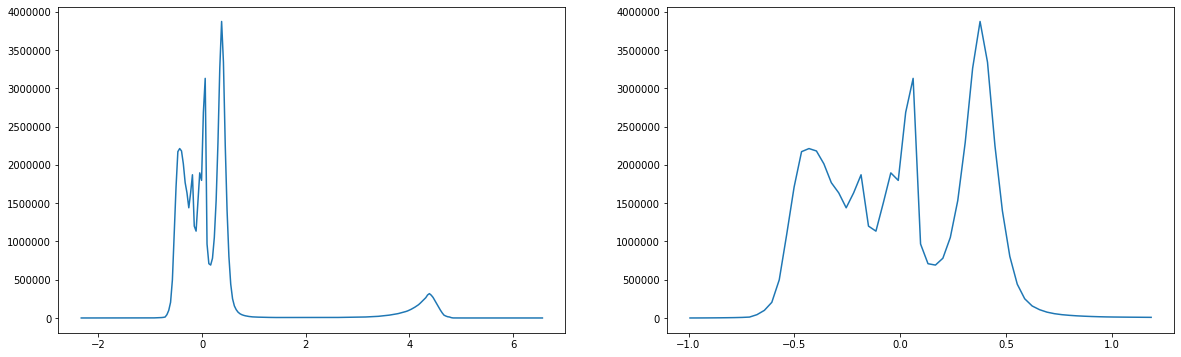

In [5]:
# Scaled data
scaled_values=np.linspace(global_min,global_max,254)
bin_edges=np.linspace(1,256,255)
scaled_count, _ = np.histogram(scaled_voxels,bins=bin_edges)
scaled_region = np.logical_and(scaled_values>-1.0,scaled_values <= 1.20)

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(scaled_values,scaled_count)
plt.subplot(1,2,2)
plt.plot(scaled_values[scaled_region],scaled_count[scaled_region])

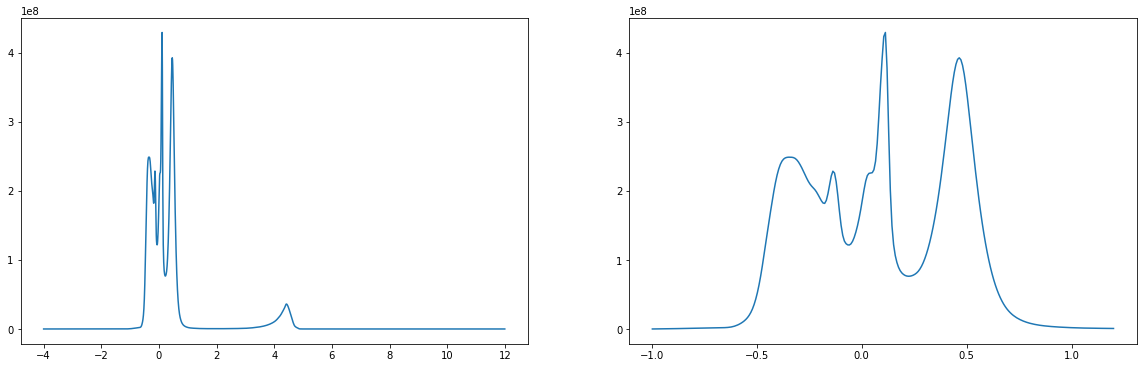

In [6]:
# Full sized data
hist_file1 = np.load("../..//Goats/tomograms/processed/y-histograms/770c-1.npz")
hist_file2 = np.load("../..//Goats/tomograms/processed/y-histograms/770c-2.npz")
hist_file3 = np.load("../..//Goats/tomograms/processed/y-histograms/770c-3.npz")
hist_file4 = np.load("../..//Goats/tomograms/processed/y-histograms/770c-4.npz")

y_hist1=hist_file1['hcounts']
y_hist2=hist_file2['hcounts']
y_hist3=hist_file3['hcounts']
y_hist4=hist_file4['hcounts']

hist_sum = np.sum(y_hist1,axis=0)+np.sum(y_hist2,axis=0)+np.sum(y_hist3,axis=0)+np.sum(y_hist4,axis=0)
hist_values = np.linspace(-3.99609375,11.99609375,2048)

full_region = np.logical_and(hist_values>-1.0,hist_values <= 1.20)

full_values = hist_values
full_count = hist_sum

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(full_values,full_count)
plt.subplot(1,2,2)
plt.plot(full_values[full_region],full_count[full_region])

Below, we get distributions:

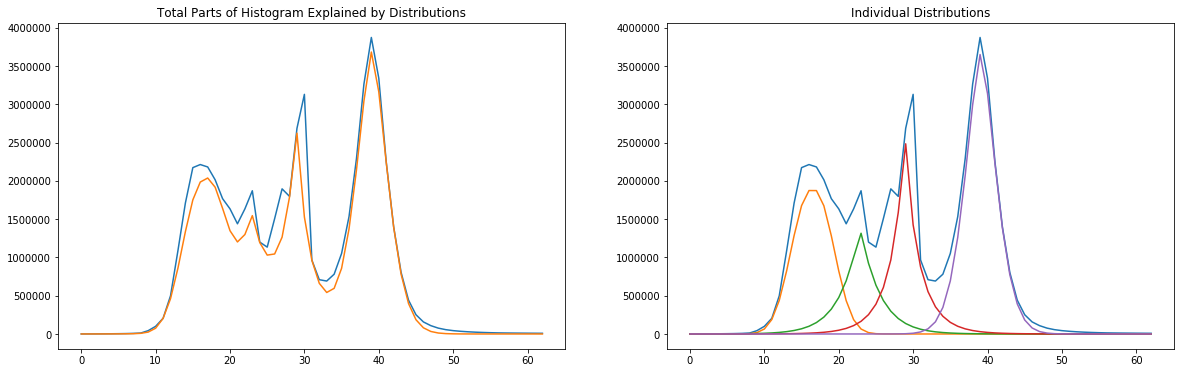

In [7]:
# Scaled probabilities
scaled_probs= get_probs(scaled_values[scaled_region], scaled_count[scaled_region])

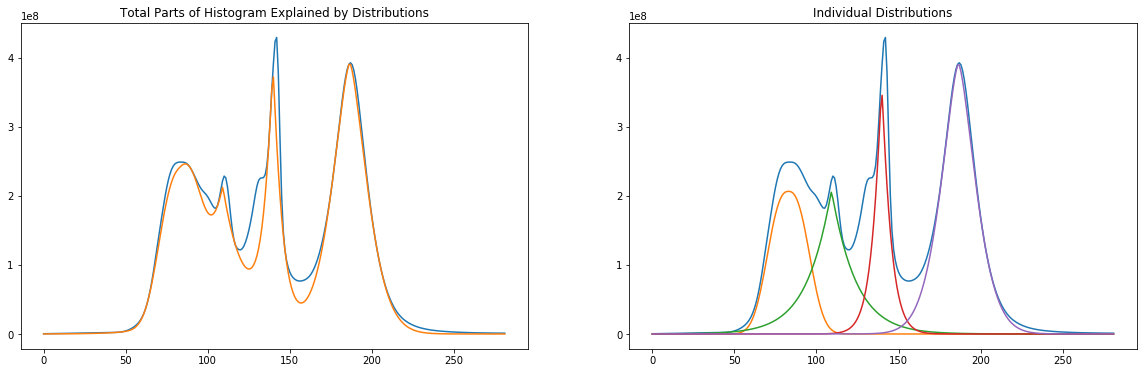

In [8]:
#Full probabilities
full_probs = get_probs(full_values[full_region], full_count[full_region])

We get the downsized bone mask on one slice of the downsized tomogram for illustration:

Region start, region end: [38] [100]


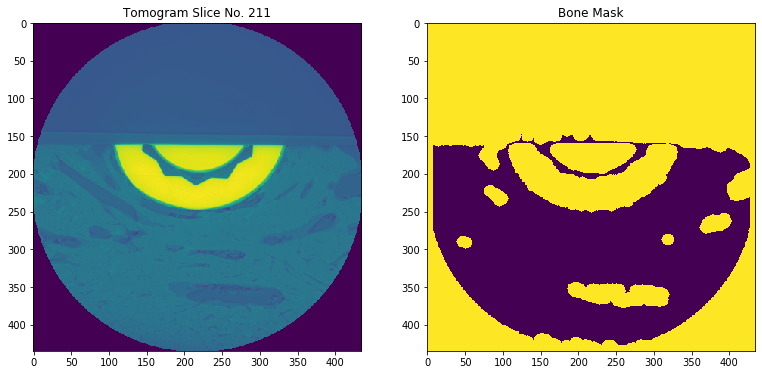

In [9]:
# One slice, scaled
z_slice_number = nz//2
scaledslice = scaled_voxels[z_slice_number,:,:]

scaledbonemask = get_bone_area(scaledslice, scaled_probs[3], scaled_region)
scaledbone=np.ma.masked_array(scaledslice,mask=scaledbonemask)
#scaledost, scaledostid = get_osteocytes(scaledbone)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(scaledslice)
plt.title(f"Tomogram Slice No. {z_slice_number}")
plt.subplot(1,3,2)
plt.imshow(scaledbonemask)
plt.title("Bone Mask");
# plt.subplot(1,3,3)
# plt.imshow(scaledost)
# plt.title("Osteocytes");

We get osteocytes for one slice of the full sized tomogram for illustration:

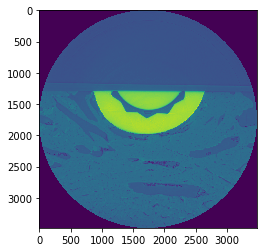

full data shape: (3384, 3480, 3480)
slice shape:     (3480, 3480)
mask shape:      (3480, 3480)


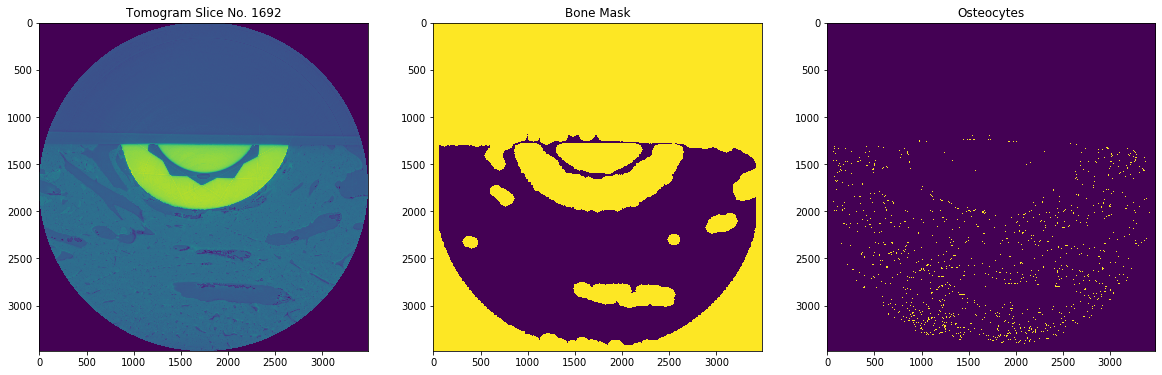

In [10]:
# One slice, full
z_slice_number = Nz//2
fullslice      = full_voxels[z_slice_number,:,:]
plt.imshow(fullslice)
plt.show()

# Turn downscaled mask into full size mask
def get_full_mask(fullslice, scaledmask):
    (Ny,Nx) = fullslice.shape
    fullmask = np.empty_like(fullslice)
    for j in range(Ny):
        for i in range(Nx):
            fullmask[j,i] = scaledmask[j//8,i//8]
    fullmask = (fullmask != 0)
    return fullmask

bigmask = get_full_mask(fullslice, scaledbonemask)
print("full data shape:",full_voxels.shape)
print("slice shape:    ",fullslice.shape)
print("mask shape:     ",bigmask.shape)

# getting osteocytes
fullbone=np.ma.masked_array(fullslice,mask=bigmask)
fullost, fullostid = get_osteocytes(fullbone)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(fullslice)
plt.title(f"Tomogram Slice No. {z_slice_number}")
plt.subplot(1,3,2)
plt.imshow(bigmask)
plt.title("Bone Mask");
plt.subplot(1,3,3)
plt.imshow(fullost)
plt.title("Osteocytes");

Below are a few cells that are commented out because they were used to get and save bone masks from the downsized data and osteocytes from the full data and take a while to run. Their results are saved in the folders "partial_full_bone_masks" and "partial_full_bone_osteocytes".

In [11]:
# # Get All scaled bone masks
# tbone0 = time()
# # Get all bone masks
# for i in range(nz):
#     sys.stdout.write("\rIteration: %i" % i) # for printing interation number
#     sys.stdout.flush() # for printing interation number
#     scaled_z_slice = scaled_voxels[i,:,:]
#     bone_area_mask = get_bone_area(scaled_z_slice,scaled_probs[3],scaled_region)
#     np.save(f"full_bone_masks/bonemask_{i}",bone_area_mask)
# tbone1 = time()
# print("Time elapsed to get all bone masks:", (tbone1-tbone0)/60, "min")

In [12]:
# # Stacking all scaled bone masks
# bones_to_stack = np.load("bone_masks/bonemask_0.npy")
# for i in range(1,nz):
#     nextbone = np.load(f"bone_masks/bonemask_{i}.npy")
#     bonestacking = np.dstack((bones_to_stack,nextbone))
#     bones_to_stack = bonestacking
    
# print("z-slice shape:   ",scaledslice.shape)
# print("scaled voxels:   ",scaled_voxels.shape)
# print("scaled bonemasks:",bones_to_stack.shape)
# plt.imshow(bones_to_stack[:,:,nz//2]);
# np.save("bone_masks/all_scaled_bonemasks",bones_to_stack)

In [13]:
# # Load in full downsized bone mask
# bones_to_stack = np.load("bone_masks/all_scaled_bonemasks.npy")
# plt.imshow(bones_to_stack[:,ny//2,:])

In [14]:
# # On part of full data
# full_voxelsz   = full_voxels[Nz//2-64:Nz//2+64,:,:]
# full_voxels128 = full_voxels[Nz//2-64:Nz//2+64,(Ny//2+900)-64:(Ny//2+900)+64,Nx//2-64:Nx//2+64]
# print(full_voxelsz.shape,full_voxels128.shape)

# plt.figure(figsize=(20,10))
# plt.subplot(1,2,1); plt.imshow(full_voxelsz[0,:,:])
# plt.subplot(1,2,2); plt.imshow(full_voxels128[0,:,:])

# # Get full masks for a part of data
# # for i in range(Nz//2-64,Nz//2+64):
# #     sys.stdout.write("\rIteration: %i" % i) # for printing interation number
# #     sys.stdout.flush() # for printing interation number
# #     fullslice = full_voxels[i,:,:]
# #     scaledmask = bones_to_stack[:,:,i//8]
# #     full_mask = get_full_mask(fullslice, scaledmask)
# #     np.save(f"partial_full_bone_masks/z_fullbonemask_{i}",full_mask)

In [15]:
# # Stacking partial full bone masks
# bones_to_stack = np.load(f"partial_full_bone_masks/z_fullbonemask_{Nz//2-64}.npy")
# for i in range(Nz//2-64+1,Nz//2+64):
#     nextbone = np.load(f"partial_full_bone_masks/z_fullbonemask_{i}.npy")
#     bonestacking = np.dstack((bones_to_stack,nextbone))
#     bones_to_stack = bonestacking

# np.save("partial_full_bone_masks/all_z_fullbonemasks",bones_to_stack)

In [16]:
# # Get full osteocytes
# tost0 = time()
# #for i in range(Nz//2-64,Nz//2+64):
# for i in range(1666,Nz//2+64):
#     sys.stdout.write("\rIteration: %i" % i) # for printing interation number
#     sys.stdout.flush() # for printing interation number
#     z_slice = full_voxels[i,:,:]
#     bone_mask = np.load(f"partial_full_bone_masks/z_fullbonemask_{i}.npy")
#     # Use bone mask to get bone mineral
#     bone=np.ma.masked_array(z_slice,mask=bone_mask)
#     # Get osteocytes
#     ost, ostid = get_osteocytes(bone)
#     np.save(f"partial_full_osteocytes/z_fullosteocytes_{i}",ost)
# tost1 = time()
# print("\nTime elapsed to get all osteocytes:", (tost1-tost0)/60, "min")

In [17]:
# # See some osteocytes
# z_slice_number = 1666 # there are 1628 - 1756

# bone_plot = np.load(f"partial_full_bone_masks/z_fullbonemask_{z_slice_number}.npy")
# ost_plot = np.load(f"partial_full_osteocytes/z_fullosteocytes_{z_slice_number}.npy")

# plt.figure(figsize=(20,10))
# plt.subplot(1,3,1)
# plt.imshow(full_voxels[z_slice_number,:,:])
# plt.title(f"Tomogram Slice No. {z_slice_number}")
# plt.subplot(1,3,2)
# plt.imshow(bone_plot)
# plt.title("Bone Mask")
# plt.subplot(1,3,3)
# plt.imshow(ost_plot)
# plt.title("Osteocytes");

In [18]:
# # Distance Transform of a single slice
# import scipy.ndimage as ndi

# z_slice_number = 1666 # there are 1628 - 1756
# tom = full_voxels[z_slice_number,:,:]
# bone_plot = np.load(f"partial_full_bone_masks/z_fullbonemask_{z_slice_number}.npy")
# ost_plot = np.load(f"partial_full_osteocytes/z_fullosteocytes_{z_slice_number}.npy")

# tomosteocytes=tom*~ost_plot
# distimg = tomosteocytes
# disttrans2 = ndi.distance_transform_edt(distimg)

# maskeddistbone = np.ma.masked_array(disttrans2,mask=bone_plot)
# boneostdist = maskeddistbone[~maskeddistbone.mask].data

# healthy_thresh = 80/1.85 #43.2432432
# healthy_bone = disttrans2 < healthy_thresh

# print(f"percentage of bone below threshold={(len(boneostdist[boneostdist < healthy_thresh])/len(boneostdist))}")

Below we run the code that automatically quantifies bone health for a 128 x 3400 x 3400 piece of the full tomogram.

In [19]:
bone_health = []
for i in range(Nz//2-64,Nz//2+64): # For proof of concept, set range = Nz//2-64,Nz//2+64
    z_slice_number = i
    fullslice = full_voxels[z_slice_number,:,:] 
    sys.stdout.write("\rIteration: %i" % i) # for printing interation number
    sys.stdout.flush() # for printing interation number
#     bonemask = get_bone_area(fullslice, full_probs[3], full_region)
#     fullbone = np.ma.masked_array(fullslice,mask=bonemask)
#     fullost, fullostid = get_osteocytes(fullbone)
    bonemask = np.load(f"partial_full_bone_masks/z_fullbonemask_{z_slice_number}.npy") # loading in bone mask because we already made them above
    fullost = np.load(f"partial_full_osteocytes/z_fullosteocytes_{z_slice_number}.npy")# loading in ostecytes because we already found them above
    tomosteocytes=fullslice*~fullost
    disttrans = ndi.distance_transform_edt(tomosteocytes)
    maskeddistbone = np.ma.masked_array(disttrans,mask=bonemask)
    boneostdist = maskeddistbone[~maskeddistbone.mask].data
    healthy_thresh = 80/1.85 #43.2432432
    healthy_bone = disttrans < healthy_thresh
    healthy_bone_percentage = len(boneostdist[boneostdist < healthy_thresh])/len(boneostdist)
    bone_health.append(healthy_bone_percentage)

Iteration: 1755

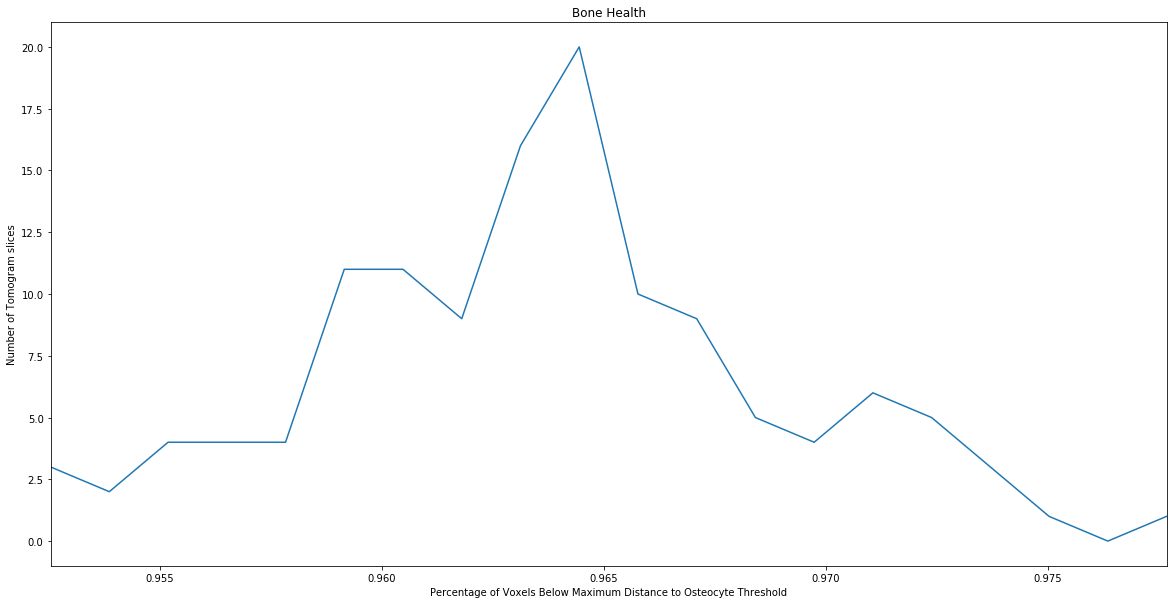

In [20]:
cnt, bins = np.histogram(bone_health,bins=20)
vals = (bins[1:]+bins[:-1])/2

plt.figure(figsize=(20,10))
plt.plot(vals,cnt)
plt.xlim([vals.min(), vals.max()])
plt.ylabel("Number of Tomogram slices")
plt.xlabel("Percentage of Voxels Below Maximum Distance to Osteocyte Threshold")
plt.title("Bone Health")
plt.savefig("figures/slicehealthyosteothreshhold.png",bbox_inches='tight')